# The Battle of Neighborhoods (Week 1) by Jomelanie G. Lee

# 1. Introduction

Singapore is a business hub, the country has experience one of the most rapid emerging economy over the past 50 years. It is a highly developed market economy along with other countries such as Hong Kong, South Korea and Taiwan. Singapore is also ranked as one of the safest country in the world and with its excellent transportation and structures, it entices large amount of foreign investments. 
<br>
<br>
Singapore proud to have a diverse population. They have high tolerance on different races and religion. With this environment, it attracts expats from different parts of the world to settle or work there. With all the inconvenience and safety it has to offer, it is one of the best place for expats to live in. However, Singapore is also one of the densest country in the world. Rental prices are high and majority of the properties are provided by the government. Government housing are only available to Citizens and Permanent Residents. The only way for foreigners to have their own property is if it is a condomium. 
<br>
<br>
In Singapore, "Condo" or "Condominium" are terms used for private housing development that comprises a collection of housing units with exclusive features like security guards, swimming pools and a gymnasium. Condominiums in Singapore come in the form of studio units, penthouse units, individual houses or multiple-room units.
<br>
<br>
Buying condominiums can also be used as an investment as it can be rented straight away once received by its owner. This contribute to the increase in value of condominiums that are already build versus those that are on pre-sell. This opts buyers to purchase upcoming condominiums instead of those ready-made ones. 
<br>
<br>
With high demand for up-coming condomiums, many property developers are trying to build as much as they can to fill-in the gap. This opens opportunities to Property Consultants to showcase and sell different properties to perspective buyers. Property consultants must have in-depth knowledge of the latest property trends and should assist buyers in finding the right houses for their buyers. 

## 1.1 Problem Statement/ Business requirement

There are many pre-sale of condominiums right now. As a property consultant, it is your job to give the right recommendations to interested clients on which condominium they should avail. The client should provide the ideal condominium that they have in mind and you should suggest a similar of better condominium that is available in your sales list. 
<br>
<br>
You should look at the similarities of their ideal condominium based on their amenities, and accessibility to its venues. Once you have a list of similar condominiums, recommend the one with the best price. 


# 2. Data Acquisition and Preprocessing


<b> Client ideal Condominium sample data</b> 
<li>We can pick a random condominium from: https://www.propertyguru.com.sg/condo-directory/search/name/A
<li> No of Bedrooms-Random number (1-4)

<br>

<b> Sales List </b> <br>
This is the current list of all pre-sale condominiums in Singapore:
<br>
http://www.mysgprop.com/2018-complete-list-new-condominiums-in-singapore/

From the above website, we can extract the following:
<li> List of current pre-sale condominiums- We only need those condominiums that has a link to its website.
<li> List of amenities each condominium has to offer-We can compare the similarities of their ideal condominium to the list that we have. We can extract this information from each website.
<li> Prices per unit/per sqf.
    
<br>
<br>
By using foursquare, we can check the venues surrounding their ideal condominium and compare all the venues surrounding the condominiums in our list. We can compare the similarities and advise which venues are similar to what they prefer. 

We need to get the top 5 similar condominiums and rank them based on prices.

### 2.1 Acquire and preprocess data

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
import folium # map rendering library
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
print('Libraries imported.')

Libraries imported.


In [2]:
#Install beautiful soup
#!conda install beautifulsoup4
#!conda install lxml
#!conda install html5lib
#!conda install requests
#!conda install -c conda-forge folium=0.5.0 --yes 
#!conda install -c conda-forge geopy --yes 

print('APIs installed.')

APIs installed.


In [3]:
from bs4 import BeautifulSoup
import requests
import string
import random

<b> 2.1.1 Get the Random Variables</b>

Generate a random link for https://www.stproperty.sg/ to generate a random condominium that we will call 'The Ideal Condominium' and "The Unlikely Condominium".
This is where we will base all our clusters.

<ul><li>Once the two condos are selected, scrape its website to gather details such as name, district, developer,address and ameneties.</li>
<li>Generate the geolocation based from the addresses</li></ul>

##### 2.1.1.1. The Ideal Condominium

In [4]:
## Get dummy data of what condominium is client's ideal condo.
ranletter=random.choice (string.ascii_letters)

url='https://www.stproperty.sg/condominium-directory/index-'+ ranletter+'/page1/size-50/'
#print (url)
source=requests.get(url).text
soup1=BeautifulSoup(source,'lxml')

#scape the website, get if there are any result
#clienttable=soup1.find_all('div',class_='list-item-content')

data = []
for row in soup1.find_all('div',class_='col-xs-8'):
    row_data = []
    for td in row.find_all('h4'):
        td_check = td.find('a')
        if td_check is not None:
            link = td.a['href']
            data.append(link)

samplechoice=random.choice(data)

if len(samplechoice)>0:
    idealcondourl="https://www.stproperty.sg"+samplechoice
    print("The idea condo of client is " ,idealcondourl)
else:
    print ("no selected condo, try again")
    raise Exception("no selected condo, try again")


The idea condo of client is  https://www.stproperty.sg/condominium-directory/landbay-condo-condo/10612


##### Scrape details from the ideal condo
1. Get the list
2. Get the geolocation

In [5]:
source=requests.get(idealcondourl).text

soup=BeautifulSoup(source,'lxml')

In [6]:
dummy=soup.find('div',class_='page-header')

#get project name
projname=dummy.contents[1].text.strip()

#get address and district
address=dummy.contents[2].text.strip()
address=address.splitlines()

#get developer
devdummy=soup.find('div',class_='detail-tab-content')
developer='Unknown'
for row in devdummy.find_all('div',class_='row'):
    row_data = []
    td_check = row.find('div',class_='col-xs-4')
    if td_check is not None:
        if td_check.text=='Developer:':
            developer = row.find('div',class_='col-xs-8').text.strip() if len(row.find('div',class_='col-xs-8').text.strip()) >0 else 'Unknown' 

            
#create and store in dataframe          
columns=['Project ID','District','Project Name','Address','Developer','Est Units','Web link', 'Latitude', 'Longitude']
chosencondodf=pd.DataFrame(columns=columns)

#Get the geolocation
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address[0].strip())
print(address[0].strip())
try:
    latitude = location.latitude
    longitude = location.longitude
except: 
    
    latitude =0
    longitude = 0

chosencondodf=chosencondodf.append({'Project ID':1100,
                                    'District': address[1].split(" ",1)[0].strip() ,
                                    'Project Name': projname ,
                                    'Address': address[0],
                                    'Developer': developer,
                                    'Est Units':0,
                                    'Web link':idealcondourl,
                                    'Latitude': latitude,
                                    'Longitude': longitude}, ignore_index=True)


chosencondodf


3 JALAN HAJIJAH, Singapore 468704


,Project ID,District,Project Name,Address,Developer,Est Units,Web link,Latitude,Longitude
0,1100,D16,Landbay Condo,"3 JALAN HAJIJAH, Singapore 468704 ...",Unknown,0,https://www.stproperty.sg/condominium-director...,0,0


In [7]:
#if latitude==0 :
#    raise Exception("no geo location")
# If there are no generated Geolocation. Enter the Latitude and Longtitude manually
# Get them from this website https://www.latlong.net/
chosencondodf.Latitude=1.290475
chosencondodf.Longitude=103.852036
#chosencondodf.Proj_id=chosencondodf.Proj_id.astype(str)

chosencondodf

,Project ID,District,Project Name,Address,Developer,Est Units,Web link,Latitude,Longitude
0,1100,D16,Landbay Condo,"3 JALAN HAJIJAH, Singapore 468704 ...",Unknown,0,https://www.stproperty.sg/condominium-director...,1.290475,103.852036


##### Get the ameneties listed for our Ideal Condominium
1. Get the list
2. Get the geolocation

In [8]:
columns=["Name"]
idealamenetiesdf=pd.DataFrame(columns=columns)
idealamenetiesdf=idealamenetiesdf.append({"Name": projname},ignore_index=True)
                                          
#Get list of ameneties
dummy=soup.find('div',class_='tab-pane',id='facilities')
amenitieslist = []
if dummy is not None:
    for ul in dummy.findAll('li'):
        licheck=ul.findAll('li')
        if licheck is not None:
            for li in ul.findAll('li'):
                if li.find('ul'):
                    break
                idealamenetiesdf[li.text.strip().upper()]=1
        else:
            print ('There are no listed Ameneties in the chosen condo. Please try again')

else:
    print ('There are no listed Ameneties in the chosen condo. Please try again')
    raise Exception("There are no listed Ameneties in the chosen condo. Please try again")

print ('Below are the listed of ameneties  for our Ideal Condominium')
idealamenetiesdf

Below are the listed of ameneties  for our Ideal Condominium


,Name,SECURITY,SWIMMING POOL,WADING POOL,BARBEQUE,GYM,TENNIS COURT,OUTDOOR JACUZZI
0,Landbay Condo,1,1,1,1,1,1,1


##### 2.1.1.2. Get the number of bedrooms that our client wants to buy

In [9]:
#Get the number of bedrooms that our client wants to buy
clients_no_of_rooms=random.choice ([1,2,3,4,5])

print ("Our client is looking for ", clients_no_of_rooms, " Bedroom unit")

Our client is looking for  5  Bedroom unit


##### 2.1.1.3. Get The Unlikely Condominium


In [10]:
## Get dummy data of what condominium is client's unlikely condo.
ranletter=random.choice (string.ascii_letters)

url='https://www.stproperty.sg/condominium-directory/index-'+ ranletter+'/page1/size-50/'
#print (url)
source=requests.get(url).text
soup1=BeautifulSoup(source,'lxml')

#scape the website, get if there are any result
#clienttable=soup1.find_all('div',class_='list-item-content')

data = []
for row in soup1.find_all('div',class_='col-xs-8'):
    row_data = []
    for td in row.find_all('h4'):
        td_check = td.find('a')
        if td_check is not None:
            link = td.a['href']
            data.append(link)
            
samplechoice=random.choice(data)

if len(samplechoice)>0:
    idealcondourl="https://www.stproperty.sg"+samplechoice
    print("The unlikely condo of client is " ,idealcondourl)
else:
    print ("no selected condo, try again")
    raise Exception("no selected condo, try again")

source=requests.get(idealcondourl).text
soup=BeautifulSoup(source,'lxml')

The unlikely condo of client is  https://www.stproperty.sg/condominium-directory/rafflesia-condo/10863


In [11]:

dummy=soup.find('div',class_='page-header')

#get project name
projname=dummy.contents[1].text.strip()

#get address and district
address=dummy.contents[2].text.strip()
address=address.splitlines()

#get developer
devdummy=soup.find('div',class_='detail-tab-content')
developer='Unknown'
for row in devdummy.find_all('div',class_='row'):
    row_data = []
    td_check = row.find('div',class_='col-xs-4')
    if td_check is not None:
        if td_check.text=='Developer:':
            developer = row.find('div',class_='col-xs-8').text.strip() if len(row.find('div',class_='col-xs-8').text.strip()) >0 else 'Unknown' 

            
#create and store in dataframe          
columns=['Project ID','District','Project Name','Address','Developer','Est Units','Web link', 'Latitude', 'Longitude']
unlikelycondodf=pd.DataFrame(columns=columns)

#Get the geolocation
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address[0].strip())
print('The address is ' + address[0].strip())
try:
    latitude = location.latitude
    longitude = location.longitude
except: 
    
    latitude =0
    longitude = 0

unlikelycondodf=unlikelycondodf.append({'Project ID':1100,
                                    'District': address[1].split(" ",1)[0].strip() ,
                                    'Project Name': projname ,
                                    'Address': address[0],
                                    'Developer': developer,
                                    'Est Units':0,
                                    'Web link':idealcondourl,
                                    'Latitude': latitude,
                                    'Longitude': longitude}, ignore_index=True)


unlikelycondodf

The address is 31 BISHAN STREET 21, Singapore 579801


,Project ID,District,Project Name,Address,Developer,Est Units,Web link,Latitude,Longitude
0,1100,D20,Rafflesia,"31 BISHAN STREET 21, Singapore 579801 ...",Unknown,0,https://www.stproperty.sg/condominium-director...,0,0


In [12]:
#if latitude==0 :
#    raise Exception("no geo location")
# If there are no generated Geolocation. Enter the Latitude and Longtitude manually
# Get them from this website https://www.latlong.net/
unlikelycondodf.Latitude=1.347580
unlikelycondodf.Longitude=103.843500

#unlikelycondodf.Proj_id=chosencondodf.Proj_id.astype(str)

unlikelycondodf

,Project ID,District,Project Name,Address,Developer,Est Units,Web link,Latitude,Longitude
0,1100,D20,Rafflesia,"31 BISHAN STREET 21, Singapore 579801 ...",Unknown,0,https://www.stproperty.sg/condominium-director...,1.34758,103.8435


<b> 2.1.3 Get List of current pre-sale condominiums</b>

Generate the list of pre-sale condominiums from this link: http://www.mysgprop.com/2018-complete-list-new-condominiums-in-singapore/
The website will contain a table of all the available pre-sale condominiums and it also has the link for it's details.

We need to scrape the details to get the following:
<ul><li>Project Name, District, Developer, Address and Website</li>
    <li>District</li>
    <li>Developer</li>
    <li>Address</li>
    <li>Website</li>
</ul>
After that, Generate the geolocation based from each addresses.

The websites for each condominium are not uniformed and not scrapable, because of this, I have listed the list of ameneties and prices for each condominium and saved it as an xlxs.
They are saved as 'Ameneties Data.xlsx' and 'Prices Data.xlsx'



In [13]:

web_link="http://www.mysgprop.com/2018-complete-list-new-condominiums-in-singapore/"
source=requests.get(web_link).text

soup=BeautifulSoup(source,'lxml')

#scape the website, get the table and convert to pandas dataframe
condotable=soup.find('table')
condodf = pd.read_html(str(condotable),encoding='utf-8', header=0)[0]
condodf['Web link']='None'
#condodf

data = []
for row in condotable.find_all('tr'):
    row_data = []
    for td in row.find_all('td'):
        td_check = td.find('a')
        if td_check is not None:
            link = td.a['href']
            condodf['Web link'].loc[condodf['Project Name'].str.contains(td.a.text)]=link

condodf.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


,District,Project Name,Address,Developer,Est Units,Web link
0,D01,120 Grange,120 Grange Road,Roxy-Pacific,–,http://www.mysgprop.com/120-grange-orchard/
1,D03,Margaret Ville,Margaret Drive,MCL Land,320,http://www.mysgprop.com/margaret-ville/
2,D03,Stirling Residences,Stirling Road,Logan &Nashan,1400,http://www.mysgprop.com/stirling-residences-qu...
3,D05,The Verandah,231 Pasir Panjang,Oxley,170,http://www.mysgprop.com/verandah-pasir-panjang...
4,D05,Harbour View Garden,211 Pasir Panjang Rd,Roxy-Pacific,57,http://www.mysgprop.com/harbour-view-garden-pa...


##### Get the Geolocation of each condominium

In [14]:
#Remove rows that does not have a link
condodf=condodf.drop(condodf[condodf["Web link"]=='None'].index)

#remove Chinese characters and trim project names
condodf['Project Name']=condodf['Project Name'].str.replace(r'[^\x00-\x7F]+', '')
condodf['Project Name']=condodf['Project Name'].str.strip()

#fix invalid address
condodf.loc[condodf.Address=='Bidadari / Woodleigh MRT','Address' ]='Woodleigh'
condodf.loc[condodf.Address=='Flora Drive (Jpark)','Address' ]='Flora Drive'

column_names=['District', 'Name', 'Project Name', 'Address', 'Developer', 'Est Units', 'Web link', 'Latitude', 'Longitude']
# instantiate new dataframe
newcondosdf = pd.DataFrame(columns=column_names)
print('Generating Geolocations...', end='')

# Try to get from geopy
for data in condodf.itertuples():
    address = ' {0}, Singapore'.format(data[3])
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    print(' .', end='')

    try:
        latitude = location.latitude
        longitude = location.longitude
    except: 
        latitude =0
        longitude = 0

    newcondosdf = newcondosdf.append({'District': data[1], 
                                     'Name': data[2],
                                      'Project Name': data[1] + ' ' + data[2], 
                                      'Address':  data[3], 
                                      'Developer': data[4], 
                                      'Est Units': data[5], 
                                      'Web link': data[6], 
                                      'Latitude': latitude, 
                                      'Longitude': longitude}, ignore_index=True)

#Assign a project Id
newcondosdf = newcondosdf.assign(Proj_id=(newcondosdf['Project Name']).astype('category').cat.codes)
#rename Proj_id to Project ID
newcondosdf.rename(columns={'Proj_id':'Project ID'}, inplace=True)
newcondosdf
print(' Done.')
newcondosdf.shape
print ("Initial Condominiums Table")
newcondosdf.head()

Generating Geolocations... . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Done.
Initial Condominiums Table


,District,Name,Project Name,Address,Developer,Est Units,Web link,Latitude,Longitude,Project ID
0,D01,120 Grange,D01 120 Grange,120 Grange Road,Roxy-Pacific,–,http://www.mysgprop.com/120-grange-orchard/,1.302772,103.823341,0
1,D03,Margaret Ville,D03 Margaret Ville,Margaret Drive,MCL Land,320,http://www.mysgprop.com/margaret-ville/,1.298235,103.805611,1
2,D03,Stirling Residences,D03 Stirling Residences,Stirling Road,Logan &Nashan,1400,http://www.mysgprop.com/stirling-residences-qu...,1.296462,103.803399,2
3,D05,The Verandah,D05 The Verandah,231 Pasir Panjang,Oxley,170,http://www.mysgprop.com/verandah-pasir-panjang...,1.288834,103.775657,5
4,D05,Harbour View Garden,D05 Harbour View Garden,211 Pasir Panjang Rd,Roxy-Pacific,57,http://www.mysgprop.com/harbour-view-garden-pa...,1.272621,103.801761,3


<b> 2.1.4  Get prices data of our list of condos  </b>

In [15]:
pricesdp = pd.read_excel('Prices Data.xlsx')
print ("Initial Prices Table")
pricesdp.head(2)

Initial Prices Table


,No of Bedrooms,Size sqft,D01 120 Grange,D14 33 Residences,D08 70 Truro,D09 8 Hullet,D19 Affinity (Former Serangoon Ville),D15 Amber45,D14 Arena Residences,D18 Casa Al Mare,...,D12 Parkwood Residences,D19 Riverfront Residences (former Rio Casa),D16 Sea Pavillion,D14 Sixteen35,D03 Stirling Residences,D19 The Garden Residences,D15 The Ramford,D18 The Tapestry,D05 The Verandah,D19 Woodleigh Residences
0,1,<450,819000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,899000.0,899000.0,NaN,NaN,618030.0,NaN,NaN
1,1,>450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,632000.0,NaN,NaN,NaN,697960.0,NaN,722100.0,738000.0,614000.0


##### After we have gathered all the data, we need to filter-out which condominium has the available rooms that the client is looking for. The result of that will be our list of new condominiums.

In [16]:
pricesdp=pricesdp.loc[pricesdp['No of Bedrooms']== clients_no_of_rooms]
pricesdp=pricesdp.replace ({pd.np.nan:0.00})
pricesdp = pricesdp.loc[:, (pricesdp != 0).any(axis=0)]
pricesdp=pricesdp.drop ('No of Bedrooms', 1)
newcondosdf=newcondosdf.loc[newcondosdf['Project Name'].isin(list(pricesdp))]
print ("the table shape is " + str(newcondosdf.shape) )
newcondosdf.head(2)

the table shape is (7, 10)


,District,Name,Project Name,Address,Developer,Est Units,Web link,Latitude,Longitude,Project ID
5,D05,Kent Ridge Hills Residences,D05 Kent Ridge Hills Residences,60 South Buona Vista Road,Oxley,598,http://www.mysgprop.com/kent-ridge-hill-reside...,1.29391,103.785675,4
9,D12,Parkwood Residences,D12 Parkwood Residences,208 Yio Chu Kang Road,Oxley`,18,http://www.mysgprop.com/parkwood-residences-oxley,1.36669,103.875520,10


<b> 2.1.5 Get nearby venues using Foursquare </b>

We will use foursquare to extract nearby venues for our list of condos and client's ideal condo. we will use these data in comparing venues between condominium and to get the top 5 condominiums based on venues.

In [17]:
#Initialize needed variables and functions
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

CLIENT_ID = '43T434JZQOA3SSDEKRFGYOSXOFH3DAJBFHU0MWEBLHTM0DVB' # your Foursquare ID
CLIENT_SECRET = 'SOFPDSOSEPSHU5AV2VVPFDV5QEQMBRQM5KQT2FORBP2XH2IV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius=500
LIMIT=100

print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(name_id, names, latitudes, longitudes, radius=500):
    
    venues_list=[]

    print('Processing ids:  ', end='')
    for name_id, name, lat, lng in zip(name_id,names, latitudes, longitudes):
        print(name_id, end='')

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name_id,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        print('.. ', end='')   
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Project ID',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('..Done', end='')
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
print ("Initialization for getting Foursquare Venue is complete!")

Your credentails:
Initialization for getting Foursquare Venue is complete!


##### Get nearby venues for our Ideal Condominium

In [18]:
ideal_venues = getNearbyVenues(chosencondodf['Project ID'],
                                   names=chosencondodf['Project Name'],
                                   latitudes=chosencondodf['Latitude'],
                                   longitudes=chosencondodf['Longitude']
                                  )
print(ideal_venues.shape)
print('There are {} uniques venues.'.format(len(ideal_venues['Venue Category'].unique())) + " for our Ideal Condominium")


ideal_venues.shape


Processing ids:  1100.. ..Done(80, 8)
There are 57 uniques venues. for our Ideal Condominium


(80, 8)

In [19]:
# one hot encoding
ideal_onehot = pd.get_dummies(ideal_venues[['Venue Category']], prefix="", prefix_sep="")
ideal_onehot.rename(columns={'Neighborhood': 'Neigh'},inplace=True)

# add neighborhood column back to dataframe
ideal_onehot['Neighborhood'] = ideal_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ideal_onehot.columns[-1]] + list(ideal_onehot.columns[:-1])
ideal_onehot = ideal_onehot[fixed_columns]

ideal_grouped = ideal_onehot.groupby('Neighborhood').mean().reset_index()

#generate idealvenuedf
projname=ideal_grouped['Neighborhood'][0]
idealvenuedf=ideal_grouped.copy()
idealvenuedf.set_index('Neighborhood',inplace=True)
idealvenuedf=idealvenuedf.T
idealvenuedf.columns.values[0] = 'Venue Freq'
idealvenuedf['Project ID']=projname
idealvenuedf['Venue Freq'] = idealvenuedf['Venue Freq'].astype(float)
idealvenuedf.reset_index()

# Rank the venues for the ideal condo
num_top_venues = ideal_grouped.shape[1]-1

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ideal_venues_sorted = pd.DataFrame(columns=columns)
ideal_venues_sorted['Neighborhood'] = ideal_grouped['Neighborhood']

for ind in np.arange(ideal_grouped.shape[0]):
    ideal_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ideal_grouped.iloc[ind, :], num_top_venues)
print ("Venues of our Ideal Condominium by ranking")
ideal_venues_sorted

Venues of our Ideal Condominium by ranking


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,48th Most Common Venue,49th Most Common Venue,50th Most Common Venue,51th Most Common Venue,52th Most Common Venue,53th Most Common Venue,54th Most Common Venue,55th Most Common Venue,56th Most Common Venue,57th Most Common Venue
0,Landbay Condo,Italian Restaurant,Cocktail Bar,Performing Arts Venue,Coffee Shop,French Restaurant,Shopping Mall,Hotel,Bar,Concert Hall,...,Spanish Restaurant,Lighthouse,Japanese Restaurant,Waterfront,Indian Restaurant,Seafood Restaurant,History Museum,Gym / Fitness Center,General Entertainment,Wings Joint


##### Get nearby venues for our Unlikely Condominium

In [20]:
unlikely_venues = getNearbyVenues(unlikelycondodf['Project ID'],
                                   names=unlikelycondodf['Project Name'],
                                   latitudes=unlikelycondodf['Latitude'],
                                   longitudes=unlikelycondodf['Longitude']
                                  )
print(unlikely_venues.shape)
print('There are {} uniques categories.'.format(len(unlikely_venues['Venue Category'].unique())) + " for our Unlikely Condominium")


#unlikely_venues.head()

Processing ids:  1100.. ..Done(6, 8)
There are 5 uniques categories. for our Unlikely Condominium


In [21]:
# one hot encoding
unlikely_onehot = pd.get_dummies(unlikely_venues[['Venue Category']], prefix="", prefix_sep="")
unlikely_onehot.rename(columns={'Neighborhood': 'Neigh'},inplace=True)

# add neighborhood column back to dataframe
unlikely_onehot['Neighborhood'] = unlikely_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [unlikely_onehot.columns[-1]] + list(unlikely_onehot.columns[:-1])
unlikely_onehot = unlikely_onehot[fixed_columns]

unlikely_grouped = unlikely_onehot.groupby('Neighborhood').mean().reset_index()

#generate unlikelyvenuedf
projname=unlikely_grouped['Neighborhood'][0]
unlikelyvenuedf=unlikely_grouped.copy()
unlikelyvenuedf.set_index('Neighborhood',inplace=True)
unlikelyvenuedf=unlikelyvenuedf.T
unlikelyvenuedf.columns.values[0] = 'Venue Freq'
unlikelyvenuedf['Project ID']=projname
unlikelyvenuedf['Venue Freq'] = unlikelyvenuedf['Venue Freq'].astype(float)
unlikelyvenuedf.reset_index()

# Rank the venues for the unlikely condo
num_top_venues = unlikely_grouped.shape[1]-1

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
unlikely_venues_sorted = pd.DataFrame(columns=columns)
unlikely_venues_sorted['Neighborhood'] = unlikely_grouped['Neighborhood']

for ind in np.arange(unlikely_grouped.shape[0]):
    unlikely_venues_sorted.iloc[ind, 1:] = return_most_common_venues(unlikely_grouped.iloc[ind, :], num_top_venues)
print ("Venues of our Unlikely Condominium by ranking")
unlikely_venues_sorted

Venues of our Unlikely Condominium by ranking


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Rafflesia,Food Court,Thai Restaurant,Restaurant,Italian Restaurant,Arts & Crafts Store


##### Get nearby venues for list of Pre-sale Condominiums

In [22]:
newcondos_venues = getNearbyVenues(name_id=newcondosdf['Project ID'],
                                   names=newcondosdf['Project Name'],
                                   latitudes=newcondosdf['Latitude'],
                                   longitudes=newcondosdf['Longitude']
                                  )
print(newcondos_venues.shape)
print('There are {} uniques categories.'.format(len(newcondos_venues['Venue Category'].unique())))


#newcondos_venues.head()

Processing ids:  4.. 10.. 11.. 14.. 21.. 24.. 23.. ..Done(105, 8)
There are 53 uniques categories.


In [23]:
# one hot encoding
newcondos_onehot = pd.get_dummies(newcondos_venues[['Venue Category']], prefix="", prefix_sep="")
newcondos_onehot.rename(columns={'Neighborhood': 'Neigh'},inplace=True)

# add neighborhood column back to dataframe
newcondos_onehot['Neighborhood'] = newcondos_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newcondos_onehot.columns[-1]] + list(newcondos_onehot.columns[:-1])
newcondos_onehot = newcondos_onehot[fixed_columns]

newcondos_grouped = newcondos_onehot.groupby('Neighborhood').mean().reset_index()

#generate newcondosvenuedf
projname=newcondos_grouped['Neighborhood'][0]
newcondosvenuedf=newcondos_grouped.copy()
newcondosvenuedf.set_index('Neighborhood',inplace=True)
newcondosvenuedf=newcondosvenuedf.T
newcondosvenuedf.columns.values[0] = 'Venue Freq'
newcondosvenuedf['Project ID']=projname
newcondosvenuedf['Venue Freq'] = newcondosvenuedf['Venue Freq'].astype(float)
newcondosvenuedf.reset_index()
newcondosvenuedf.shape


(53, 8)

In [24]:
# Get top 10 venues for the newcondos condo
num_top_venues = newcondos_grouped.shape[1]-1

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
newcondos_venues_sorted = pd.DataFrame(columns=columns)
newcondos_venues_sorted['Neighborhood'] = newcondos_grouped['Neighborhood']

for ind in np.arange(newcondos_grouped.shape[0]):
    newcondos_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newcondos_grouped.iloc[ind, :], num_top_venues)
    
print ("Venues of our available pre-sale Condominiums")
newcondos_venues_sorted.head()

Venues of our available pre-sale Condominiums


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,44th Most Common Venue,45th Most Common Venue,46th Most Common Venue,47th Most Common Venue,48th Most Common Venue,49th Most Common Venue,50th Most Common Venue,51th Most Common Venue,52th Most Common Venue,53th Most Common Venue
0,D05 Kent Ridge Hills Residences,Coffee Shop,Café,Noodle House,Food Court,Sandwich Place,Vietnamese Restaurant,Fried Chicken Joint,Medical Center,Korean Restaurant,...,Garden,Gas Station,General Entertainment,Gym,Park,Indian Restaurant,Juice Bar,Vegetarian / Vegan Restaurant,Pet Store,Asian Restaurant
1,D12 Parkwood Residences,Coffee Shop,Chinese Restaurant,Supermarket,Bus Line,Bus Station,Indian Restaurant,Pet Store,Filipino Restaurant,Gym,...,Office,Noodle House,Nightclub,Mexican Restaurant,Metro Station,Medical Center,Martial Arts Dojo,Malay Restaurant,Korean Restaurant,Asian Restaurant
2,D13 Park Colonial,Gym,Bus Station,Convenience Store,Park,General Entertainment,Metro Station,Bus Line,Nightclub,Soccer Field,...,Office,Noodle House,Mexican Restaurant,Medical Center,Martial Arts Dojo,Malay Restaurant,Korean Restaurant,Vegetarian / Vegan Restaurant,Juice Bar,Asian Restaurant
3,D14 Parc Esta @Eunos (Former Eunosville),Asian Restaurant,Seafood Restaurant,Thai Restaurant,Food Court,Noodle House,Chinese Restaurant,Bus Station,Casino,Juice Bar,...,Hong Kong Restaurant,Park,Office,Nightclub,Metro Station,Medical Center,Martial Arts Dojo,Korean Restaurant,Indian Restaurant,Kebab Restaurant
4,D18 The Tapestry,Martial Arts Dojo,Bowling Alley,Garden,Seafood Restaurant,Bus Station,Café,Vietnamese Restaurant,Filipino Restaurant,Gym,...,Park,Office,Noodle House,Nightclub,Mexican Restaurant,Metro Station,Medical Center,Malay Restaurant,Korean Restaurant,Asian Restaurant


<b> 2.1.6 Get ameneties data of our list of condos  </b>

In [25]:
#Get the list of ameneties from the csv
import types
import pandas as pd

amenetiesdp = pd.read_excel('Ameneties Data.xlsx')

#let's preprocess data needed for venue comparison.
amenetiesdp.columns=map(str.upper,amenetiesdp.columns )
amenetiesdp=amenetiesdp.replace ({pd.np.nan:0})
amenetiesdp=amenetiesdp.replace ({'Y':1})
amenetiesdp.head(2)

,AMENETIES,SECURITY,ACCESSIBLE TOILET,AIR/VIEWING DECK,AQUA GYMNASIUM,AQUA DECK,ATRIUM,BUBBLE POOL/ JACUZZI,BARBEQUE,BBQ,...,VIRTUAL GOLF,WET DECK,WATERFALL/ CASCADING STREAM,WATER CORRIDOR,WATER LOUNGE,JOGGING TRAIL.1,TENNIS COURT,URBAN FARM,YOGA AREA,TREE HOUSE
0,D01 120 Grange,1,1,0,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0
1,D14 33 Residences,1,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0


# 3. Methodology

In this assignment, we need to recommend the best condominium for our client. We need to look in the three aspects: Venue, amenities and price. 

After gathering all the needed data, First we need to get the similar condominiums based on Venues. We can use the K-Means modeling to get cluster similar to our ideal condominium. We will use  the cluster similar to our ideal condominium as the filtered list for our next step. 

Second step is to get the best condominium based on amenities from the cluster that we have extracted. We need to get the top 5 condominiums based on the amenities that our ideal condominiums have. We will use CONTENT-BASED FILTERING as a method in achieving this. 

After we have filter out the best 5 condominium based on venue and ameneties, our third and final step is to get the cheapest price, we will have to get the prices of each of our top 5 condominiums and the best price will be our Recommended Condominium to our client.

# 4. Result Section

#### 4.1. Get Similar condominiums based on Venues


1. Balance all columns. make sure that all 3 dfs have the same number of columns
2. make sure that columns are in correct order.
3. train k_means. 2 clusters
4. draw in map


In [26]:
merged_columns=list(ideal_grouped)+list(unlikely_grouped)+list(newcondos_grouped)
merged_columns=list(set(merged_columns))
merged_columns.remove('Neighborhood')
merged_columns.sort()

#Create new_ideal_grouped with all available columns
new_ideal_grouped=pd.DataFrame(columns=['Neighborhood'] + merged_columns)
new_ideal_grouped=new_ideal_grouped.astype('float64')
new_ideal_grouped=pd.concat([new_ideal_grouped,ideal_grouped], sort=False)
new_ideal_grouped=new_ideal_grouped.replace ({pd.np.nan:0.0000})

#Create new_unlikely_grouped with all available columns
new_unlikely_grouped=pd.DataFrame(columns=['Neighborhood'] + merged_columns)
new_unlikely_grouped=new_unlikely_grouped.astype('float64')
new_unlikely_grouped=pd.concat([new_unlikely_grouped,unlikely_grouped], sort=False)
new_unlikely_grouped=new_unlikely_grouped.replace ({pd.np.nan:0.0000})

centroidarray=np.array(new_ideal_grouped.drop('Neighborhood',1).values.tolist() + 
                      new_unlikely_grouped.drop('Neighborhood',1).values.tolist())

#Create new_newcondos_grouped with all available columns
newcondos_grouped
new_newcondos_grouped=pd.DataFrame(columns=['Neighborhood'] + merged_columns)
new_newcondos_grouped=new_newcondos_grouped.astype('float64')
new_newcondos_grouped=pd.concat([new_newcondos_grouped,newcondos_grouped], sort=False)
new_newcondos_grouped=new_newcondos_grouped.replace ({pd.np.nan:0.000000})

# import k-means from clustering stage
from sklearn.cluster import KMeans


new_newcondos_clustering = new_newcondos_grouped.drop('Neighborhood', 1)
new_newcondos_clustering
# run k-means clustering
kmeans = KMeans(init=centroidarray, n_clusters=2)
kmeans=kmeans.fit(new_newcondos_clustering)

# add clustering labels
newcondos_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
newcondosdf=newcondosdf.set_index('Project Name')

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

newcondos_venues_sorted=newcondos_venues_sorted.set_index('Neighborhood') 
newcondo_merged = newcondos_venues_sorted

# merge the result with newcondosdf to add latitude/longitude for each neighborhood
newcondo_merged = newcondo_merged.join(newcondosdf)
newcondo_merged.reset_index()
print ("Done")
print ("The shape is of our pre-sale condominiums table is ", newcondo_merged.shape)
#newcondo_merged.head()

Done
The shape is of our pre-sale condominiums table is  (7, 63)


/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


##### Map clusters

In [27]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [28]:
print ("Below is the map of Singapore and the location of our condominiums")
# create map
map_clusters = folium.Map(width=1000,height=500,location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(2)
ys = [i + x + (i*x)**2 for i in range(2)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


cluster_label=np.array(newcondo_merged['Cluster Labels']).astype('str')
cluster_label[cluster_label=='1']='Unlikely'
cluster_label[cluster_label=='0']='Ideal'

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, cluster_no in zip(newcondo_merged['Latitude'], newcondo_merged['Longitude'], newcondo_merged['Name'],cluster_label,newcondo_merged['Cluster Labels']):
    label= '<b> ' + str(poi) + '</b> <br> Cluster Type: ' + str(cluster)
    label = folium.Popup(label, parse_html=False) 
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster_no-1],
        fill=True,
        fill_color=rainbow[cluster_no-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Below is the map of Singapore and the location of our condominiums


### Cluster of our Ideal Condo

In [29]:
filtered_newcondo=newcondo_merged.loc[newcondo_merged['Cluster Labels'] == 0, newcondo_merged.columns[[1] + list(range(5, newcondo_merged.shape[1]))]]
print ("We have found " + str(filtered_newcondo.shape [0]) + " condominium/s that have the same cluster as our ideal condo. First few data are below:")
filtered_newcondo[list(filtered_newcondo)[:11]].head()

We have found 6 condominium/s that have the same cluster as our ideal condo. First few data are below:


,1st Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue
Neighborhood,,,,,,,,,,,
D05 Kent Ridge Hills Residences,Coffee Shop,Sandwich Place,Vietnamese Restaurant,Fried Chicken Joint,Medical Center,Korean Restaurant,Hong Kong Restaurant,Frozen Yogurt Shop,Food,Filipino Restaurant,Convenience Store
D12 Parkwood Residences,Coffee Shop,Bus Station,Indian Restaurant,Pet Store,Filipino Restaurant,Gym,General Entertainment,Gas Station,Garden,Frozen Yogurt Shop,Fried Chicken Joint
D13 Park Colonial,Gym,General Entertainment,Metro Station,Bus Line,Nightclub,Soccer Field,Thrift / Vintage Store,Track,Fried Chicken Joint,Food,Frozen Yogurt Shop
D14 Parc Esta @Eunos (Former Eunosville),Asian Restaurant,Noodle House,Chinese Restaurant,Bus Station,Casino,Juice Bar,Vegetarian / Vegan Restaurant,Malay Restaurant,Mexican Restaurant,Convenience Store,Pet Store
D19 Park Colonial,Park,Metro Station,Café,Chinese Restaurant,Convenience Store,Filipino Restaurant,Gas Station,Garden,Frozen Yogurt Shop,Fried Chicken Joint,Food Court


### Cluster of our Unlikely Condo

In [30]:
unlikely=newcondo_merged.loc[newcondo_merged['Cluster Labels'] == 1, newcondo_merged.columns[[1] + list(range(5, newcondo_merged.shape[1]))]]
print ("Below are the condos that your client will unlikely pick: ")
unlikely=unlikely.reset_index()
unlikely[list(unlikely)[:11]].head()

Below are the condos that your client will unlikely pick: 


,Neighborhood,1st Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue
0,D18 The Tapestry,Martial Arts Dojo,Bus Station,Café,Vietnamese Restaurant,Filipino Restaurant,Gym,General Entertainment,Gas Station,Frozen Yogurt Shop,Fried Chicken Joint


#### 4.2. Get best condominium based on amenities
We need to get the top 5 condominiums based on the amenities that our ideal condominiums have. We will use CONTENT-BASED FILTERING as a method in achieving this.

1. Get list of preferred amenities
2. Using list from clustered condos, get their amenities.
3. Use CONTENT-BASED FILTERING to get top 5 condos
3. List down ameneties available for each.



In [31]:
filtered_newcondo=filtered_newcondo.reset_index()
filtered_ameneties= amenetiesdp.loc[amenetiesdp['AMENETIES'].isin(filtered_newcondo.Neighborhood.values.tolist())]

print ("the shape is " , filtered_ameneties.shape)

# Balance columns: Combine column headers
merged_columns=list(filtered_ameneties)+list(idealamenetiesdf)
merged_columns=list(set(merged_columns))
merged_columns.remove('AMENETIES')
merged_columns.remove('Name')
merged_columns.sort()
print ("We have total of " + str(len(merged_columns)) + " ameneties")

print ("Creating new ideal ameneties dataframe with complete columns....")
#Create new_filtered_ameneties with all available columns
new_idealamenetiesdf=pd.DataFrame(columns=['Name'] + merged_columns)
new_idealamenetiesdf=new_idealamenetiesdf.astype('float64')
new_idealamenetiesdf=pd.concat([new_idealamenetiesdf,idealamenetiesdf], sort=False)
new_idealamenetiesdf=new_idealamenetiesdf.replace ({pd.np.nan:0.0000})
print ("Done")

print ("Creating new condominiums ameneties dataframe with complete columns....")
#Create new_filtered_ameneties with all available columns
new_filtered_ameneties=pd.DataFrame(columns=['AMENETIES'] + merged_columns)
new_filtered_ameneties=new_filtered_ameneties.astype('float64')
new_filtered_ameneties=pd.concat([new_filtered_ameneties,filtered_ameneties], sort=False)
new_filtered_ameneties=new_filtered_ameneties.replace ({pd.np.nan:0.0000})

print ("Done")

print ("Remove Name column in preparation for our computation.")
new_ameneties=new_filtered_ameneties.drop('AMENETIES', 1)
print ("Done")

print ("Perform computation....")
temp=new_idealamenetiesdf.drop('Name', 1)
templist=temp.iloc[0,:]
templist

scoredbyamenities_df = ((new_ameneties*templist).sum(axis=1))/(templist.sum())
#Sort our recommendations in descending order
scoredbyamenities_df = scoredbyamenities_df.sort_values(ascending=False)
print ("Below are our result: ")
scoredbyamenities_df.head(10)

the shape is  (6, 87)
We have total of 87 ameneties
Creating new ideal ameneties dataframe with complete columns....
Done
Creating new condominiums ameneties dataframe with complete columns....
Done
Remove Name column in preparation for our computation.
Done
Perform computation....
Below are our result: 


21    0.714286
13    0.714286
17    0.428571
20    0.285714
19    0.285714
18    0.285714
dtype: float64

In [32]:
print ("The top 5 condominiums are :")
top5condosbyamenetiesdf=new_filtered_ameneties.loc[scoredbyamenities_df.head(5).keys()]
top5condosbyamenetiesdf=top5condosbyamenetiesdf.reset_index()
top5condosbyamenetiesdf [['AMENETIES']]

The top 5 condominiums are :


,AMENETIES
0,D19 Riverfront Residences (former Rio Casa)
1,D05 Kent Ridge Hills Residences
2,D14 Parc Esta @Eunos (Former Eunosville)
3,D12 Parkwood Residences
4,D19 Park Colonial


In [33]:
top5condos=top5condosbyamenetiesdf
rank=0
topcondoforameneties=str(top5condos['AMENETIES'].head(1)[0])
for hood in top5condos['AMENETIES']:
    rank=rank+1
    print("----Rank "+ str(rank) + "----")
    temp = top5condos[top5condos['AMENETIES'] == hood].T
    temp=temp[temp.apply(lambda x:x==1).any(1)]
    temp=temp.reset_index()
    #print(temp['index'])
    print(hood)
    print("With "+ str(temp.shape[0]) +" ameneties listed")
    print('\n')

----Rank 1----
D19 Riverfront Residences (former Rio Casa)
With 37 ameneties listed


----Rank 2----
D05 Kent Ridge Hills Residences
With 29 ameneties listed


----Rank 3----
D14 Parc Esta @Eunos (Former Eunosville)
With 28 ameneties listed


----Rank 4----
D12 Parkwood Residences
With 5 ameneties listed


----Rank 5----
D19 Park Colonial
With 11 ameneties listed




Text(0.5, 1.0, 'Top 5 Condominium Comparison by ')

<Figure size 864x288 with 0 Axes>

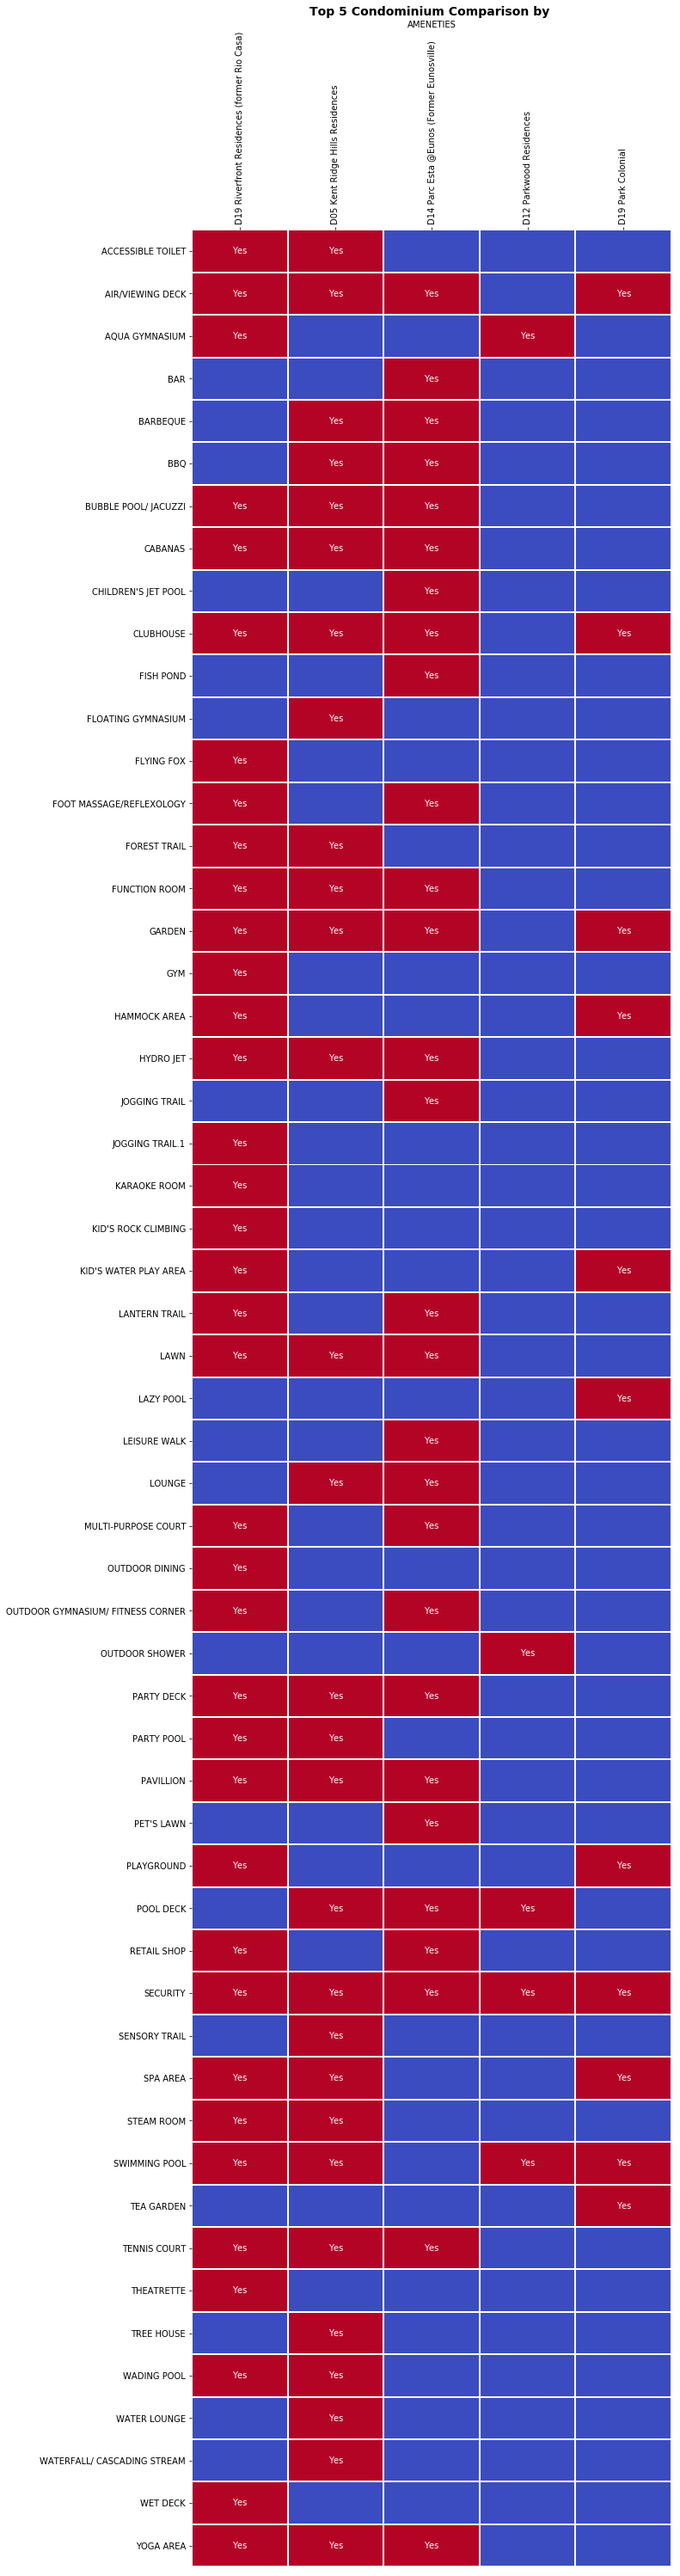

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plot_data=top5condos.drop('index', axis=1)
plot_data=plot_data.set_index('AMENETIES')
plot_data=plot_data.T
plot_data=plot_data[plot_data.apply(lambda x:x==1).any(1)]

label=np.array(plot_data)
label=np.array(plot_data).astype('str')
label[label=='1.0']='Yes'
label[label=='0.0']=''

fig = plt.figure( figsize=(12,4) )
fig, (ax) = plt.subplots(1, 1, figsize=(10,50))
hm = sns.heatmap(plot_data, 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 linewidths=1,
                 center=.5,
                 annot=label,
                 fmt='',
                 cbar=False)
xlabels = ['Top 1', 'Top 2', 'Top 3', 'Top 4']
hm.xaxis.tick_top() # x axis on top
hm.set_xticklabels(hm.get_xticklabels(),rotation ='vertical')
hm.xaxis.set_label_position('top')
hm.set_title('Top 5 Condominium Comparison by ',
            fontsize=14, 
            fontweight='bold')


#### 4.3. Get the Price of our top 5 Condomoniums for our client

In [35]:
print("Our client is looking for " + str(clients_no_of_rooms) + " bedrooms.")

Our client is looking for 5 bedrooms.


In [36]:
best_avg_price=1000000000000
bestcondo="unknown"
rank=0
top_ameneties_price=0
top5prices=pd.DataFrame(columns=['Neighborhood', 'Average Price'])
for hood in top5condos['AMENETIES']:
    rank=rank+1
    print("----Rank "+ str(rank) + ":  "+hood+"----")
    temp = pricesdp[['Size sqft', hood]]
    temp[hood]= temp[hood].astype("float64")
    temp=temp.loc[temp[hood]>=1]
    price_avg=temp[hood].mean()
    temp[hood]=temp[hood].map('S${:,.2f}'.format)
    if best_avg_price>price_avg:
        best_avg_price=price_avg
        bestcondo=hood
    if topcondoforameneties==hood:
        top_ameneties_price=price_avg
    temp=temp.set_index('Size sqft')

    print(temp)
    print(hood + "- Average price for " + str(clients_no_of_rooms) + " room/s is S${:,.2f}".format( price_avg))
    print('\n')
    top5prices=top5prices.append({'Neighborhood': str(hood),
                                  'Average Price': float(price_avg)},ignore_index=True)
    

----Rank 1:  D19 Riverfront Residences (former Rio Casa)----


/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


          D19 Riverfront Residences (former Rio Casa)
Size sqft                                            
>1650                                  S$2,045,000.00
D19 Riverfront Residences (former Rio Casa)- Average price for 5 room/s is S$2,045,000.00


----Rank 2:  D05 Kent Ridge Hills Residences----
          D05 Kent Ridge Hills Residences
Size sqft                                
>1750                      S$2,803,000.00
D05 Kent Ridge Hills Residences- Average price for 5 room/s is S$2,803,000.00


----Rank 3:  D14 Parc Esta @Eunos (Former Eunosville)----
          D14 Parc Esta @Eunos (Former Eunosville)
Size sqft                                         
<1650                               S$2,234,000.00
D14 Parc Esta @Eunos (Former Eunosville)- Average price for 5 room/s is S$2,234,000.00


----Rank 4:  D12 Parkwood Residences----
          D12 Parkwood Residences
Size sqft                        
<2000              S$2,500,000.00
D12 Parkwood Residences- Average price for 5 roo

Text(0.5, 1.0, 'Top 5 Condominium by Average Price for 5 bedroom/s.')

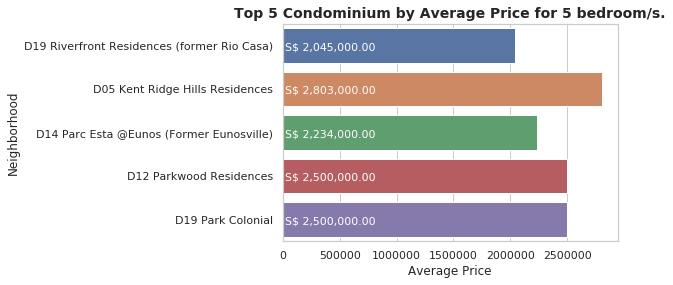

In [37]:

import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="Average Price", y="Neighborhood", data=top5prices)
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(20000, i.get_y()+.5, \
           "S$ {:,.2f}".format(i.get_width()), fontsize=11, color='white')
ax.set_title('Top 5 Condominium by Average Price for '+ str(clients_no_of_rooms) + ' bedroom/s.',
            fontsize=14, 
            fontweight='bold')

# 5. Discussion Section

In [38]:
print ("\t In this run, our client's Ideal Condominium is -" + chosencondodf["Project Name"][0] +". He hopes that we can find him a pre-sell condominium similar to it.")
print ("He does not like similar condominiums like  -" + unlikelycondodf["Project Name"][0] +". He does not like the venue there.")

print ("\n \t After our analysis, we can confidently advise that... \n")

print ("\t The best pre-sale Condominium that we can recommend to our client is " + bestcondo + '.')
print ("The average price for a " + str(clients_no_of_rooms) + " bedroom/s is S${:,.2f}".format( best_avg_price))

if topcondoforameneties==bestcondo:
    print ("\t It is also ranked as the best in ameneties")
else:
    print ("\t You can also recommend " + topcondoforameneties.upper() + " as it has the best ameneties that the client might like.")
    print ("The average price for a " + str(clients_no_of_rooms) + " bedroom/s is S${:,.2f}".format( top_ameneties_price))

	 In this run, our client's Ideal Condominium is -Landbay Condo. He hopes that we can find him a pre-sell condominium similar to it.
He does not like similar condominiums like  -Rafflesia. He does not like the venue there.

 	 After our analysis, we can confidently advise that... 

	 The best pre-sale Condominium that we can recommend to our client is D19 Riverfront Residences (former Rio Casa).
The average price for a 5 bedroom/s is S$2,045,000.00
	 It is also ranked as the best in ameneties


# 6. Conclusion

In this assignment, I was able to learn and apply many things that I have learned in this course. I was able to scrape websites using Beautiful Soup, use Pandas Dataframes, geolocation, play with folium and Four Square. 

This assignment also demonstrate the application of k-Means and CONTENT-BASED FILTERING. It also demonstrate how to make two seaborn plots as graphical representation of our results. 

We can use this assignment as a draft for more complicated logic in generating recommendations. We can add additional criteria like trends or crime rates/safety levels to make it more accurate.



# THANK YOU